# Notebook to train LLMs with LoRA

using Unsloth

- [All Unsloth models](https://docs.unsloth.ai/get-started/all-our-models)
- [Other Unsloth notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


# Choose model to train

Change following params if you want:
- `MODEL_NAME` - which model you want to train
- `WANDB_PROJECT_NAME` - name of Weights&Biases project, where you'll be watching loss graph
- `OUTPUT_DIR` - directory for saving model checkpoints during training
- `TRAINED_MODEL_NAME_TO_SAVE` - path for saving final model

In [1]:
AVAILABLE_MODELS = [
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Qwen2.5-7B-Instruct-bnb-4bit"
]

In [23]:
MODEL_NAME = "unsloth/Qwen2.5-7B-Instruct-bnb-4bit"
WANDB_PROJECT_NAME = "ru-news__Qwen2.5-7B-Instruct"
OUTPUT_DIR = "qwen_7b_instruct"
TRAINED_MODEL_NAME_TO_SAVE = "ru-news_qwen-7b-instruct_lora-model"

In [24]:
assert MODEL_NAME in AVAILABLE_MODELS  # You can also choose other model from Unsloth

Add tokens if you want to use Weights&Biases for graphs and HuggingFace for saving model

In [ ]:
USER_SECRETS = {
    "huggingface_username": "HF_USERNAME",
    "huggingface_token": "HF_TOKEN",
    "wandb_api_key": "WANDB_API_KEY"
}

In [31]:
HF_PATH = f'{USER_SECRETS.get("huggingface_username")}/{TRAINED_MODEL_NAME_TO_SAVE}'
HF_PATH

'ezuryy/ru-news_qwen-7b-instruct_lora-model'

Train & Inference Unsloth params

In [26]:
MAX_SEQ_LENGTH = 1024 
DTYPE = None        # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
LOAD_IN_4BIT = True # Use 4bit quantization to reduce memory usage. Can be False.

Prompt for generation

In [27]:
NEWS_PROMPT = """Напиши новостную статью, заголовком которой мог бы быть:
{}

Текст статьи:
"""
title = "Олимпийская чемпионка Елена Веснина стала почетным гражданином Сочи"

prompt = NEWS_PROMPT.format(title)

# Installation

In [8]:
# !pip install wandb
# !pip install unsloth

# Look at data

Dataset is based on [Ilya Gusev ru_news](https://huggingface.co/datasets/IlyaGusev/ru_news)

- It's filtered by text length (100-1000 symbols)
- Removed special symbols like `\xa0` (meaning space)
- Remain 1 615 000 `(title, text)` pairs for training LLM to generate news `text` by it's `title`. Using columns `(cleaned_title, cleaned_text)` for this purpose

In [9]:
import pandas as pd

df = pd.read_csv("df_train.csv")
df.head()

,url,text,title,source,timestamp,cleaned_title,cleaned_text,len_cleaned_text
0,https://tass.ru/armiya-i-opk/2732317,"МОСКВА, 11 марта. /ТАСС/. Строительство новых ...",Минобороны РФ переносит строительство новых со...,ods_tass,1457733972,Минобороны РФ переносит строительство новых со...,Строительство новых объектов социально-культур...,795
1,https://tass.ru/proisshestviya/3182992,"МЕХИКО, 6 апреля. /Корр. ТАСС Иван Валюк/. Пор...",В Мексике около 50 человек пострадали в ДТП с ...,ods_tass,1459994012,В Мексике около 50 человек пострадали в ДТП с ...,Порядка 50 человек пострадали и один погиб в Д...,702
2,http://perm.rusplt.ru/index/amkar-syigral-vnic...,29 марта в Перми на стадионе «Звезда» состоялс...,«Амкар» сыграл вничью с «Уфой»,buriy,1427704291,«Амкар» сыграл вничью с «Уфой»,29 марта в Перми на стадионе «Звезда» состоялс...,773
3,https://tass.ru/proisshestviya/607448,"ЛОС-АНДЖЕЛЕС, 14 апреля. /Корр. ИТАР-ТАСС Алек...",В штате Вашингтон сошли несколько снежных лави...,ods_tass,1365929760,В штате Вашингтон сошли несколько снежных лави...,На горнолыжном курорте в Сиэтле /штат Вашингто...,388
4,http://www.vesti.ru/doc.html?id=2435101,Прибыль FedEx выросла сильнее ожиданий рынка Р...,Прибыль FedEx выросла сильнее ожиданий рынка,buriy,1426683600,Прибыль FedEx выросла сильнее ожиданий рынка,Распечатать Чистая прибыль FedEx Corp. выросла...,949


In [10]:
df.shape

(1615862, 8)

Histogram of text length (symbols) which we'll use for training

<Axes: >

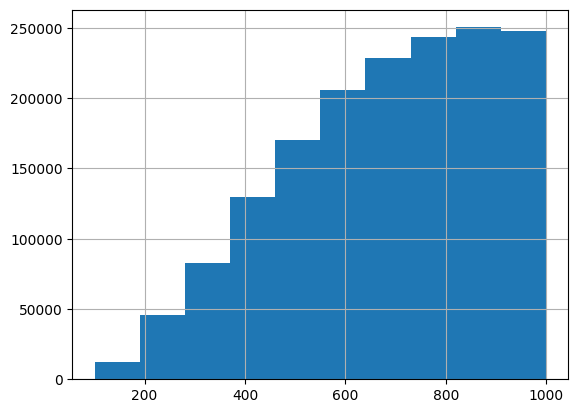

In [11]:
df["len_cleaned_text"].hist()

# Unsloth config

In [12]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = MODEL_NAME, 
    max_seq_length = MAX_SEQ_LENGTH,
    dtype = DTYPE,
    load_in_4bit = LOAD_IN_4BIT,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.14: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.621 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [13]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.14 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


# Prepare prompt

In [14]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, GenerationConfig
import torch


inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(model.device)

generation_config = GenerationConfig(
    temperature=0.7,           # Контроль случайности (0.0-1.0, больше - креативнее)
    repetition_penalty=1.2,    # Штраф за повторения (1.0 - нет штрафа, >1.0 - меньше повторов)
    top_p=0.9,                 # Фильтрация ядра (nucleus sampling)
    do_sample=True,            # Включить стохастическое семплирование
    max_new_tokens=500,        # Максимальное количество новых токенов
    pad_token_id=tokenizer.eos_token_id
)

outputs = model.generate(
    **inputs,
    generation_config=generation_config
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Напиши новостную статью, заголовком которой мог бы быть:
Олимпийская чемпионка Елена Веснина стала почетным гражданином Сочи

Текст статьи:
Популярная российская теннисистка и олимпийская чемпионка Елена Веснина была удостоена звания почетного гражданина города Сочи. Эта честь была присвоена ей за вклад в развитие спортивной жизни региона.

Веснина известна своими выдающимися достижениями на международных сценах: она дважды становилась победителем Открытого чемпионата Австралии (2015-22), а также завоевала серебряные медали Олимпийских игр 27 лет назад. Она проявляет неизменное стремление к развитию спорта как интегрального элемента сочинской культуры.

Кроме того, Елена активно поддерживает местный спортклуб «Сокол», который был основан еще в советское время для обучения детей из малообеспеченных семей. Тренером этой школы является сама Елена Веснина, которая помогает многим детям достигать своих целей благодаря своему опыту профессионального теннисиста.

Гражданство Сочи стало ещё од

# Prepare DatasetDict

I use `df_train.csv` as Train Dataset 

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output! Otherwise you'll get infinite generations!

In [15]:
news_prompt_for_train = NEWS_PROMPT + "{}" 

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    titles = examples["cleaned_title"]
    texts  = examples["cleaned_text"]
    full_prompts = []
    for title, text in zip(titles, texts):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = news_prompt_for_train.format(title, text) + EOS_TOKEN
        full_prompts.append(text)
    return {"text" : full_prompts}


In [16]:
news_prompt_for_train

'Напиши новостную статью, заголовком которой мог бы быть:\n{}\n\nТекст статьи:\n{}'

In [17]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files='df_train.csv')
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1615862 [00:00<?, ? examples/s]

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'text', 'title', 'source', 'timestamp', 'cleaned_title', 'cleaned_text', 'len_cleaned_text'],
        num_rows: 1615862
    })
})

# Setup Huggingface & Wandb

In [19]:
from huggingface_hub import login
import wandb

hf_token = USER_SECRETS.get("huggingface_token")

login(token = hf_token)

wb_token = USER_SECRETS.get("wandb_api_key")

wandb.login(key=wb_token)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ezuryy/.netrc
wandb: Currently logged in as: ezuryy (ezury) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [20]:
wandb.init(
    project=WANDB_PROJECT_NAME,
)

# Train the model

For train example set `max_steps=60`

To really train LLM set `num_train_epochs=1`, usually it's enough


In [21]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    dataset_text_field = "text",
    max_seq_length = MAX_SEQ_LENGTH,
    dataset_num_proc = 2,
    packing = False, 
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        # num_train_epochs=1, # to really train LLM
        max_steps=60,         # for example train
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 50,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = OUTPUT_DIR,
        group_by_length=True,
        report_to="wandb",   # you can turn it off
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1615862 [00:00<?, ? examples/s]

In [28]:
trainer.model.print_trainable_parameters()

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273


In [29]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4090. Max memory = 23.621 GB.
5.668 GB of memory reserved.


In [30]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,615,862 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
50,1.304600


In [32]:
wandb.finish()

train/epoch,▁█
train/global_step,▁█
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁
total_flos,6392551839830016.0
train/epoch,0.0003
train/global_step,60
train/grad_norm,0.608
train/learning_rate,3e-05
train/loss,1.3046


In [33]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

93.7191 seconds used for training.
1.56 minutes used for training.
Peak reserved memory = 6.834 GB.
Peak reserved memory for training = 1.166 GB.
Peak reserved memory % of max memory = 28.932 %.
Peak reserved memory for training % of max memory = 4.936 %.


# Saving finetuned model

To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model

In [34]:
TRAINED_MODEL_NAME_TO_SAVE

'ru-news_qwen-7b-instruct_lora-model'

In [31]:
# Local saving

model.save_pretrained(TRAINED_MODEL_NAME_TO_SAVE)
tokenizer.save_pretrained(TRAINED_MODEL_NAME_TO_SAVE)

('ru-news_qwen-7b-instruct_lora-model/tokenizer_config.json',
 'ru-news_qwen-7b-instruct_lora-model/special_tokens_map.json',
 'ru-news_qwen-7b-instruct_lora-model/vocab.json',
 'ru-news_qwen-7b-instruct_lora-model/merges.txt',
 'ru-news_qwen-7b-instruct_lora-model/added_tokens.json',
 'ru-news_qwen-7b-instruct_lora-model/tokenizer.json')

In [36]:
# Online saving

model.push_to_hub(
    HF_PATH, 
    token = USER_SECRETS.get("huggingface_token")
)
tokenizer.push_to_hub(
    HF_PATH,  
    token = USER_SECRETS.get("huggingface_token")
)

README.md:   0%|          | 0.00/591 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/162M [00:00<?, ?B/s]

Saved model to https://huggingface.co/ezuryy/ru-news_qwen-7b-instruct_lora-model


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

# Loading finetuned model for inference

You can load model from:
- Any checkpoint, saved during training `SAVED_CHECKPOINT_PATH`
- Local path `TRAINED_MODEL_NAME_TO_SAVE`
- HuggingFace path `HF_PATH`

In [35]:
CHECKPOINT_NUMBER = 60
SAVED_CHECKPOINT_PATH = f"{OUTPUT_DIR}/checkpoint-{CHECKPOINT_NUMBER}"

In [37]:
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = SAVED_CHECKPOINT_PATH, # or TRAINED_MODEL_NAME_TO_SAVE or HF_PATH
    max_seq_length = MAX_SEQ_LENGTH,
    dtype = DTYPE,
    load_in_4bit = LOAD_IN_4BIT,
)
FastLanguageModel.for_inference(model) 

==((====))==  Unsloth 2025.3.14: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.621 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(152064, 3584, padding_idx=151654)
        (layers): ModuleList(
          (0-27): 28 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3584, out_features=3584, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3584, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [16]:
max_new_tokens = 500

inputs = tokenizer(prompt, return_tensors="pt")

outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=max_new_tokens)
print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0])

Напиши новостную статью, заголовком которой мог бы быть:
Олимпийская чемпионка Елена Веснина стала почетным гражданином Сочи

Текст статьи:
Сегодня в Сочи прошла церемония награждения олимпийской чемпионки Елены Весниной. Ее наградили почетным гражданством Сочи за заслуги перед городом. Веснина выступила на церемонии вместе с губернатором Краснодарского края Вениамином Кондратьевым. Награду Веснина получила вручение от главы администрации города Анатолия Пахомова.


You can also set params in `GenerationConfig` to avoid repetition or change creativity

In [16]:
from transformers import GenerationConfig

inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(model.device)

generation_config = GenerationConfig(
    temperature=0.6,           # Контроль случайности (0.0-1.0, больше - креативнее)
    repetition_penalty=1.2,    # Штраф за повторения (1.0 - нет штрафа, >1.0 - меньше повторов)
    top_p=0.9,                 # Фильтрация ядра (nucleus sampling)
    do_sample=True,            # Включить стохастическое семплирование
    max_new_tokens=500,        # Максимальное количество новых токенов
    pad_token_id=tokenizer.eos_token_id
)

outputs = model.generate(
    **inputs,
    generation_config=generation_config
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Напиши новостную статью, заголовком которой мог бы быть:
Олимпийская чемпионка Елена Веснина стала почетным гражданином Сочи

Текст статьи:
Сегодня в Адлерском районе Сочи состоялась церемония награждения олимпийской чемпионки 26 лет — Елены Весниной. Она была удостоена звания «Почетный гражданин города-курорта Сочи». Награду ей вручила мэр города Анна Кикабидзе.
«Я очень рада получить эту престижную награду и благодарна всем за поддержку», — сказала спортсменка после получения золотого знака отличия.
Веснина выиграла бронзу на ОИ–80 года (теннис), а также три раза становилась победителем турнира WTA Series Finals.
